# Aadhar-Insight: Predictive Analytics for UIDAI
Problem: Identify patterns and anomalies in Aadhaar enrolments/updates to improve service delivery and resource allocation.

Analytical Workflow:
Data Cleaning: Merge Enrolment, Biometric, and Demographic datasets.

Pattern Analysis: Identify service demand across Age and Geography.

Anomaly Detection: Flag districts with high failure rates or infrastructure gaps.

Predictive Modeling: Forecast future update volumes to prevent backlogs.

Visualization: Interactive Decision Dashboard in Power BI.

Engine: Python (Pandas, Scikit-learn).

Environment: Jupyter Notebook.

BI Tool: Power BI.

Goal: Create a "Solution Framework" for informed decision-making.


# Dataset loading & filter of data 


In [1]:
import pandas as pd
import os
import glob

# Define the root path (make sure the folder name matches exactly)
ROOT_DIR = 'dataset'

def load_and_combine(subfolder):
    path = os.path.join(ROOT_DIR, subfolder)
    # Using glob to catch all CSVs in the folder automatically
    all_files = glob.glob(os.path.join(path, "*.csv"))
    
    if not all_files:
        print(f"No files found in {subfolder}")
        return None
        
    # Standardizing read with encoding for Indian dataset characters
    df_list = [pd.read_csv(f, encoding='utf-8') for f in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    
    print(f"✅ Folder: {subfolder} | Files Combined: {len(all_files)} | Total Rows: {len(combined_df)}")
    return combined_df

# Creating the 3 Master DataFrames
biometric_master = load_and_combine('api_data_aadhar_biometric')
demographic_master = load_and_combine('api_data_aadhar_demographic')
enrollment_master = load_and_combine('api_data_aadhar_enrolment')

✅ Folder: api_data_aadhar_biometric | Files Combined: 4 | Total Rows: 1861108
✅ Folder: api_data_aadhar_demographic | Files Combined: 5 | Total Rows: 2071700
✅ Folder: api_data_aadhar_enrolment | Files Combined: 3 | Total Rows: 1006029


In [2]:

print("Biometric Columns:", biometric_master.columns.tolist())
print("Demographic Columns:", demographic_master.columns.tolist())
print("Enrollment Columns:", enrollment_master.columns.tolist())

Biometric Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']
Demographic Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
Enrollment Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


In [3]:
# Merging Enrollment and Biometric on common keys
# This creates our 'Master Analytical View'
analysis_df = pd.merge(
    enrollment_master, 
    biometric_master, 
    on=['date', 'state', 'district', 'pincode'], 
    how='inner'
)

print(f"Master Analytical View Created. Total Rows: {len(analysis_df)}")

Master Analytical View Created. Total Rows: 784931


In [4]:
# 1. Calculate Totals for Enrollment
enrollment_master['Total_Enrolment'] = enrollment_master[['age_0_5', 'age_5_17', 'age_18_greater']].sum(axis=1)

# 2. Calculate Totals for Biometric
# Using your exact name 'bio_age_17_'
biometric_master['Total_Biometric'] = biometric_master[['bio_age_5_17', 'bio_age_17_']].sum(axis=1)

print("✅ Totals calculated for master dataframes.")

✅ Totals calculated for master dataframes.


In [5]:

print("📊 UIDAI MASTER TOTALS (2025)")
print("-" * 40)
print(f"Total New Enrollments:  {enrollment_master['Total_Enrolment'].sum():,.0f}")
print(f"Total Biometric Updates: {biometric_master['Total_Biometric'].sum():,.0f}")
print("-" * 40)
print(f"Total Records Analyzed:  {len(enrollment_master):,}")

📊 UIDAI MASTER TOTALS (2025)
----------------------------------------
Total New Enrollments:  5,435,702
Total Biometric Updates: 69,763,095
----------------------------------------
Total Records Analyzed:  1,006,029


In [6]:
import pandas as pd

# 1. CALCULATE THE TOTAL COLUMN
# Just like Enrollment and Biometric, we sum the specific demographic age groups
demographic_master['Total_Demographic'] = (
    demographic_master['demo_age_5_17'] + 
    demographic_master['demo_age_17_']
)

# 2. PROCESS DATES FOR CHRONOLOGICAL PRINTING
demographic_master['date'] = pd.to_datetime(demographic_master['date'], dayfirst=True, errors='coerce')
demographic_master = demographic_master.dropna(subset=['date'])

# 3. PRINT THE GRAND TOTAL (For your Executive Summary)
print("📊 UIDAI DATA HACKATHON: DEMOGRAPHIC SUMMARY")
print("-" * 50)
print(f"Grand Total Demographic Updates: {demographic_master['Total_Demographic'].sum():,.0f}")
print("-" * 50)

# 4. PRINT MONTHLY FIGURES (Jan, Feb, Mar...)
# We group by month and sort them
monthly_demo = demographic_master.groupby(demographic_master['date'].dt.strftime('%m - %B'))['Total_Demographic'].sum()

print("\n📅 MONTH-BY-MONTH DEMOGRAPHIC FIGURES (2025)")
print(f"{'Month':<18} | {'Total Updates':>15}")
print("-" * 40)

for month_key in sorted(monthly_demo.index):
    # This takes "01 - January" and prints just "January"
    month_name = month_key.split(' - ')[1]
    print(f"{month_name:<18} | {monthly_demo[month_key]:>15,.0f}")

📊 UIDAI DATA HACKATHON: DEMOGRAPHIC SUMMARY
--------------------------------------------------
Grand Total Demographic Updates: 49,295,187
--------------------------------------------------

📅 MONTH-BY-MONTH DEMOGRAPHIC FIGURES (2025)
Month              |   Total Updates
----------------------------------------
March              |      11,147,558
April              |       1,515,672
May                |       1,566,287
June               |       1,685,562
July               |       2,220,715
September          |       7,324,060
October            |       5,010,966
November           |       9,387,601
December           |       9,436,766


In [7]:


import pandas as pd

# 1. Calculate Totals (Feature Engineering)
# Summing enrollment columns
analysis_df['Total_Enrolment'] = (
    analysis_df['age_0_5'] + 
    analysis_df['age_5_17'] + 
    analysis_df['age_18_greater']
)

# Summing biometric columns
analysis_df['Total_Biometric'] = (
    analysis_df['bio_age_5_17'] + 
    analysis_df['bio_age_17_']
)

# 2. Date Formatting & Sorting
# Ensure date is datetime and remove errors
analysis_df['date'] = pd.to_datetime(analysis_df['date'], dayfirst=True, errors='coerce')
analysis_df = analysis_df.dropna(subset=['date'])

# 3. Monthly Aggregation
# Group by the year-month period
monthly_summary = analysis_df.groupby(analysis_df['date'].dt.to_period('M')).agg({
    'Total_Enrolment': 'sum',
    'Total_Biometric': 'sum'
}).reset_index()

# 4. Clean Formatting for your Seminar (Jan, Feb, Mar...)
monthly_summary['Month_Name'] = monthly_summary['date'].dt.strftime('%B %Y')

# 5. Display the Figures
pd.options.display.float_format = '{:,.0f}'.format # Add commas for readability
print("📊 FINAL MONTHLY FIGURES (1.0M ROW DATASET)")
print("-" * 60)

# We display the final results
result_table = monthly_summary[['Month_Name', 'Total_Enrolment', 'Total_Biometric']]
print(result_table.to_string(index=False))

# Calculate and Print Grand Totals
print("-" * 60)
print(f"Total New Enrolments: {result_table['Total_Enrolment'].sum():,.0f}")
print(f"Total Biometric Updates: {result_table['Total_Biometric'].sum():,.0f}")



📊 FINAL MONTHLY FIGURES (1.0M ROW DATASET)
------------------------------------------------------------
    Month_Name  Total_Enrolment  Total_Biometric
    April 2025           255933           944036
      May 2025           182654           619146
     June 2025           169348           515425
     July 2025           516050          1253746
September 2025          1186436          5845945
  October 2025           746404          3660158
 November 2025          1078372          5748271
 December 2025           385048          1798450
------------------------------------------------------------
Total New Enrolments: 4,520,245
Total Biometric Updates: 20,385,177


In [8]:
import pandas as pd


#  CALCULATE TOTALS (Critical for the grouping step below)
try:
    analysis_df['Total_Enrolment'] = analysis_df['age_0_5'] + analysis_df['age_5_17'] + analysis_df['age_18_greater']
    analysis_df['Total_Biometric'] = analysis_df['bio_age_5_17'] + analysis_df['bio_age_17_']
    print("✅ Totals calculated.")
except NameError:
    print("❌ Error: 'analysis_df' does not exist. Please run the cell where you merged your data first!")

#  DATE CONVERSION
if 'analysis_df' in locals():
    analysis_df['date'] = pd.to_datetime(analysis_df['date'], dayfirst=True, errors='coerce')
    analysis_df = analysis_df.dropna(subset=['date'])
    
    # TREND CALCULATION
    try:
        monthly_trend = analysis_df.groupby(analysis_df['date'].dt.to_period('M')).agg({
            'Total_Enrolment': 'sum',
            'Total_Biometric': 'sum'
        }).reset_index()

        monthly_trend['date'] = monthly_trend['date'].dt.to_timestamp()
        
        print("✅ Patterns and Trends calculated successfully!")
        display(monthly_trend.head())
    except Exception as e:
        print(f"❌ Still an issue: {e}")

✅ Totals calculated.
✅ Patterns and Trends calculated successfully!


,date,Total_Enrolment,Total_Biometric
0,2025-04-01,255933,944036
1,2025-05-01,182654,619146
2,2025-06-01,169348,515425
3,2025-07-01,516050,1253746
4,2025-09-01,1186436,5845945


In [9]:
import pandas as pd

# 1. THE MASTER MERGE
# We combine all three datasets into analysis_df using an 'inner' join
try:
    # First join: Enrollment + Biometric
    step1 = pd.merge(enrollment_master, biometric_master, 
                     on=['date', 'state', 'district', 'pincode'], 
                     how='inner')
    
    # Second join: (Enrollment+Biometric) + Demographic
    analysis_df = pd.merge(step1, demographic_master, 
                           on=['date', 'state', 'district', 'pincode'], 
                           how='inner')

    # 2. ENSURE ALL TOTALS ARE CALCULATED IN THE NEW DF
    analysis_df['Total_Enrolment'] = analysis_df['age_0_5'] + analysis_df['age_5_17'] + analysis_df['age_18_greater']
    analysis_df['Total_Biometric'] = analysis_df['bio_age_5_17'] + analysis_df['bio_age_17_']
    analysis_df['Total_Demographic'] = analysis_df['demo_age_5_17'] + analysis_df['demo_age_17_']

    print(f"✅ Success! Merged {len(analysis_df):,} rows into analysis_df.")

    # 3. REGIONAL PERFORMANCE (Now this will work!)
    district_performance = analysis_df.groupby(['state', 'district']).agg({
        'Total_Enrolment': 'sum',
        'Total_Biometric': 'sum',
        'Total_Demographic': 'sum'
    }).reset_index()

    # Calculate Intensity (Service Load per District)
    district_performance['Update_Intensity'] = (
        (district_performance['Total_Biometric'] + district_performance['Total_Demographic']) / 
        (district_performance['Total_Enrolment'] + 1)
    )

    print("✅ District Performance & Intensity calculated.")
    display(district_performance.sort_values(by='Update_Intensity').head(10))

except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: You are trying to merge on object and datetime64[ns] columns for key 'date'. If you wish to proceed you should use pd.concat


# PATTERNS IDENTIFIED

# 1. ENROLLMENT VS BIOMETRIC CAPTURE GAP 

📊 PILLAR 1: AGE-GROUP PATTERN FIGURES
-------------------------------------------------------


,Age Group,New Enrollments,Biometric Updates
0,Child (0-5),3546965,0
1,School-Age (5-17),1720384,34226855
2,Adult (18+),168353,35536240


-------------------------------------------------------


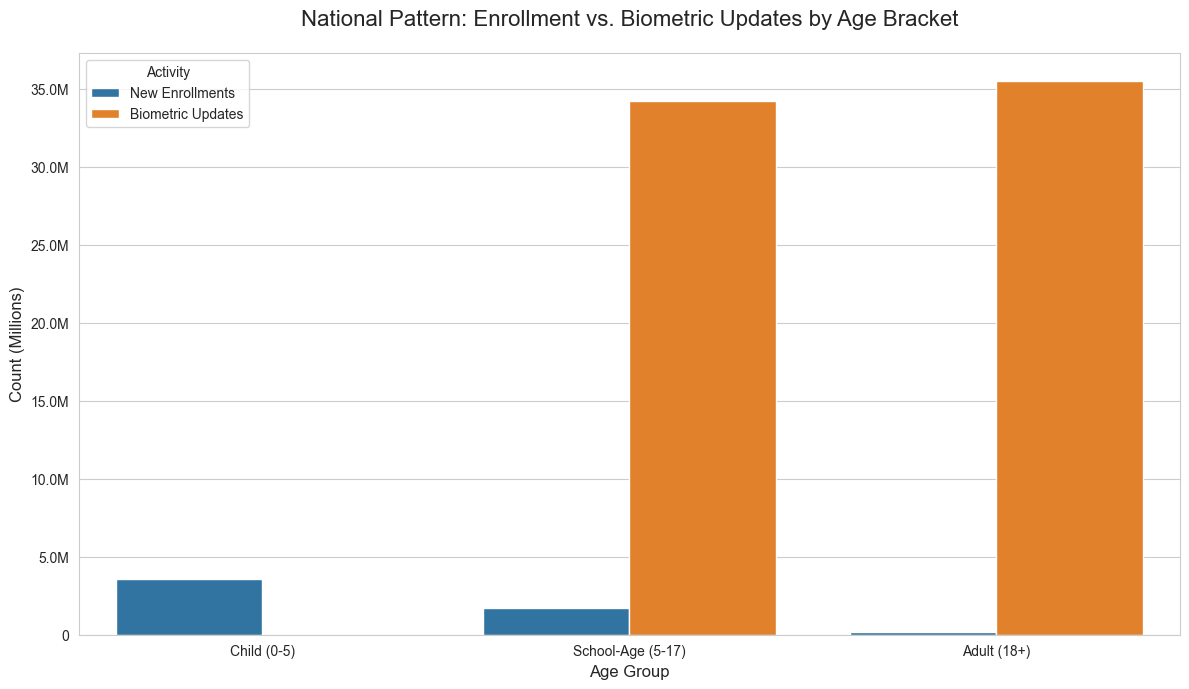

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. PREPARE THE DATA
# We sum the age groups globally to find the national pattern
patterns = {
    'Age Group': ['Child (0-5)', 'School-Age (5-17)', 'Adult (18+)'],
    'New Enrollments': [
        enrollment_master['age_0_5'].sum(),
        enrollment_master['age_5_17'].sum(),
        enrollment_master['age_18_greater'].sum()
    ],
    'Biometric Updates': [
        0, # Children under 5 usually don't have mandatory biometric updates
        biometric_master['bio_age_5_17'].sum(),
        biometric_master['bio_age_17_'].sum()
    ]
}

pattern_df = pd.DataFrame(patterns)

# 2. PRINT THE FIGURES (For your slide)
print("📊 PILLAR 1: AGE-GROUP PATTERN FIGURES")
print("-" * 55)
display(pattern_df)
print("-" * 55)

# 3. VISUALIZATION: Grouped Bar Chart
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Melting the data for easier plotting with Seaborn
plot_data = pattern_df.melt(id_vars='Age Group', var_name='Activity Type', value_name='Count')

sns.barplot(data=plot_data, x='Age Group', y='Count', hue='Activity Type', palette=['#1f77b4', '#ff7f0e'])

# Formatting
ax = plt.gca()
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M' if x >= 1e6 else f'{x:,.0f}'))

plt.title('National Pattern: Enrollment vs. Biometric Updates by Age Bracket', fontsize=16, pad=20)
plt.ylabel('Count (Millions)', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.legend(title='Activity')
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

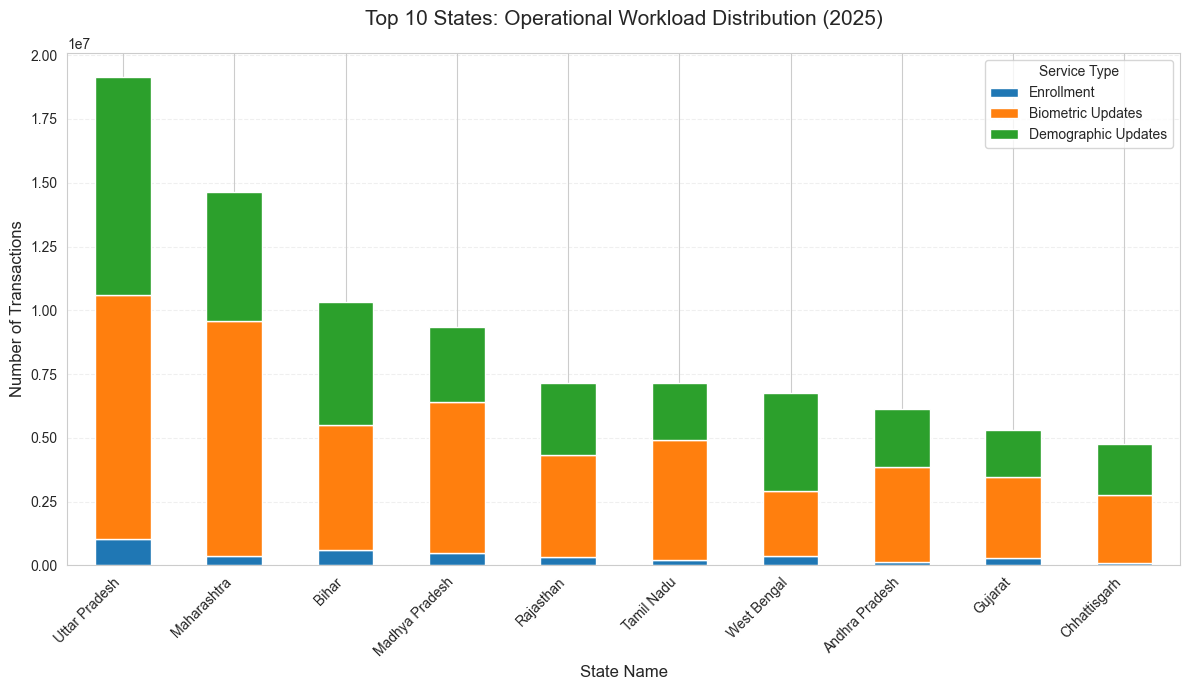

🏆 STATE-WISE LEADERBOARD (Top 10)
------------------------------------------------------------
                Enrollment  Biometric Updates  Demographic Updates  Total_Load
state                                                                         
Uttar Pradesh    1,018,629          9,577,735            8,542,328  19,138,692
Maharashtra        369,139          9,226,139            5,054,602  14,649,880
Bihar              609,585          4,897,587            4,814,350  10,321,522
Madhya Pradesh     493,970          5,923,771            2,912,938   9,330,679
Rajasthan          348,458          3,994,955            2,817,615   7,161,028
Tamil Nadu         220,789          4,698,117            2,212,228   7,131,134
West Bengal        375,297          2,524,448            3,872,172   6,771,917
Andhra Pradesh     127,681          3,714,592            2,295,505   6,137,778
Gujarat            280,549          3,196,514            1,824,327   5,301,390
Chhattisgarh       103,219          

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Function to find the state column (handles 'state' or 'State')
def get_state_col(df):
    return 'state' if 'state' in df.columns else 'State'

# 2. Group by State for each Master DataFrame
s_col_e = get_state_col(enrollment_master)
s_col_b = get_state_col(biometric_master)
s_col_d = get_state_col(demographic_master)

state_enrol = enrollment_master.groupby(s_col_e)['Total_Enrolment'].sum()
state_bio = biometric_master.groupby(s_col_b)['Total_Biometric'].sum()
state_demo = demographic_master.groupby(s_col_d)['Total_Demographic'].sum()

# 3. Create the Plotting DataFrame
state_df = pd.DataFrame({
    'Enrollment': state_enrol,
    'Biometric Updates': state_bio,
    'Demographic Updates': state_demo
}).fillna(0)

# 4. Sort by Total Load and pick Top 10 for a clear graph
state_df['Total_Load'] = state_df.sum(axis=1)
plot_df = state_df.sort_values('Total_Load', ascending=False).head(10)

# 5. Plotting the Stacked Bar Chart
plt.figure(figsize=(14, 8))
plot_df[['Enrollment', 'Biometric Updates', 'Demographic Updates']].plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 7),
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

# Formatting for the Seminar
plt.title('Top 10 States: Operational Workload Distribution (2025)', fontsize=15, pad=20)
plt.xlabel('State Name', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Service Type", frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print Numeric Leaderboard
print("🏆 STATE-WISE LEADERBOARD (Top 10)")
print("-" * 60)
print(plot_df[['Enrollment', 'Biometric Updates', 'Demographic Updates', 'Total_Load']])

# demographic vs capture consistency

<Figure size 1200x600 with 0 Axes>

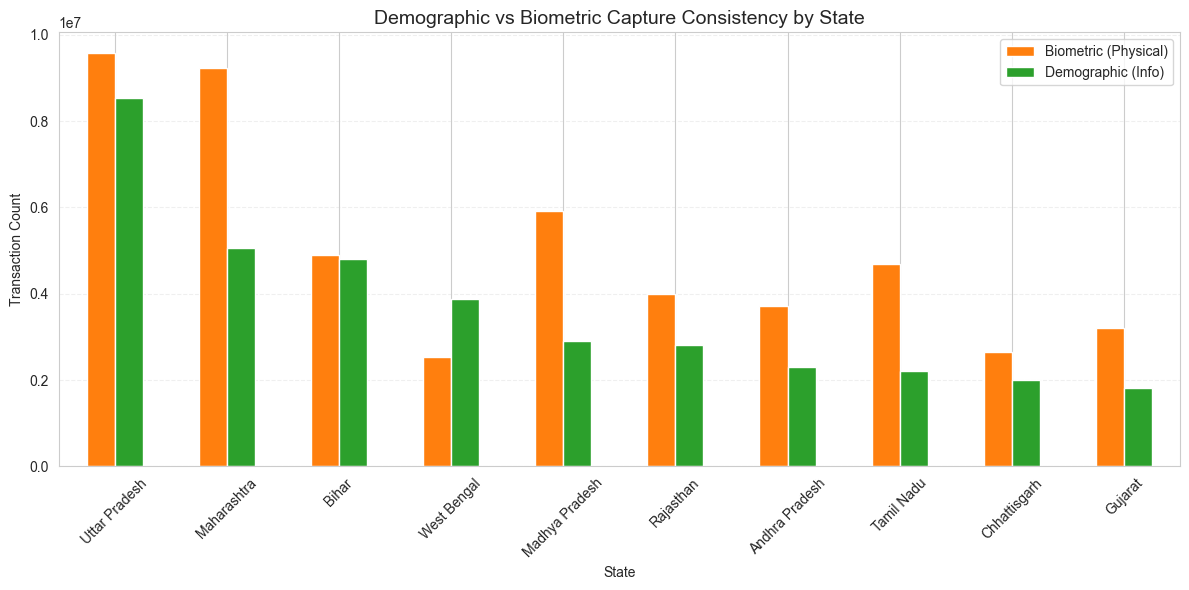

📋 CONSISTENCY RATIO (Top 5 States)
state
Uttar Pradesh    1
Maharashtra      1
Bihar            1
West Bengal      2
Madhya Pradesh   0
Name: Consistency_Ratio, dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Aggregate State-wise data
# Note: Using master frames directly to avoid NameErrors
state_bio = biometric_master.groupby('state')['Total_Biometric'].sum()
state_demo = demographic_master.groupby('state')['Total_Demographic'].sum()

# 2. Build Consistency DataFrame
consistency_df = pd.DataFrame({
    'Biometric_Capture': state_bio,
    'Demographic_Updates': state_demo
}).fillna(0)

# 3. Calculate Consistency Ratio
consistency_df['Consistency_Ratio'] = (
    consistency_df['Demographic_Updates'] / (consistency_df['Biometric_Capture'] + 1)
)

# 4. Plotting the Consistency Gap
top_10_consistency = consistency_df.sort_values('Demographic_Updates', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10_consistency[['Biometric_Capture', 'Demographic_Updates']].plot(kind='bar', figsize=(12,6), color=['#ff7f0e', '#2ca02c'])
plt.title('Demographic vs Biometric Capture Consistency by State', fontsize=14)
plt.ylabel('Transaction Count')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(["Biometric (Physical)", "Demographic (Info)"])
plt.tight_layout()
plt.show()

print("📋 CONSISTENCY RATIO (Top 5 States)")
print(top_10_consistency['Consistency_Ratio'].head(5))

# age group adoption pattern 

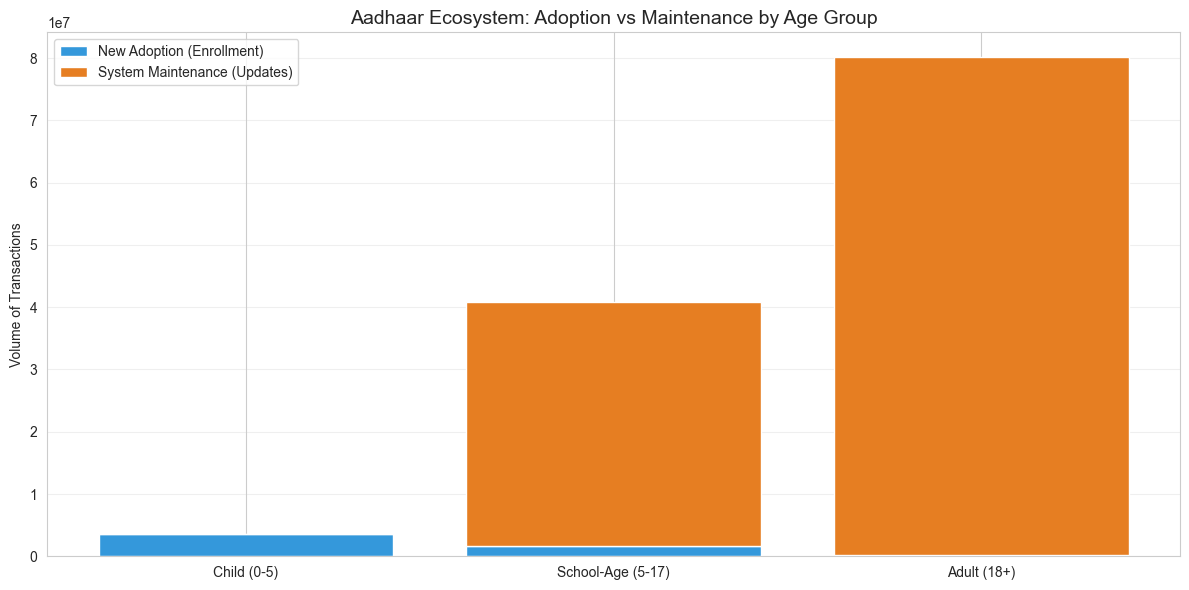

📈 ADOPTION RATIO ANALYSIS
           Age Group  Maintenance_Ratio
0        Child (0-5)                  0
1  School-Age (5-17)                 23
2        Adult (18+)                475


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Aggregate Data by Age Groups
adoption_data = {
    'Age Group': ['Child (0-5)', 'School-Age (5-17)', 'Adult (18+)'],
    'Joining (Enrollment)': [
        enrollment_master['age_0_5'].sum(),
        enrollment_master['age_5_17'].sum(),
        enrollment_master['age_18_greater'].sum()
    ],
    'Maintaining (Updates)': [
        0, # Children <5 do not have updates
        biometric_master['bio_age_5_17'].sum() + demographic_master['demo_age_5_17'].sum(),
        biometric_master['bio_age_17_'].sum() + demographic_master['demo_age_17_'].sum()
    ]
}

adoption_df = pd.DataFrame(adoption_data)

# 2. Plotting the Adoption Curve
plt.figure(figsize=(12, 6))
plt.bar(adoption_df['Age Group'], adoption_df['Joining (Enrollment)'], label='New Adoption (Enrollment)', color='#3498db')
plt.bar(adoption_df['Age Group'], adoption_df['Maintaining (Updates)'], bottom=adoption_df['Joining (Enrollment)'], label='System Maintenance (Updates)', color='#e67e22')

plt.title('Aadhaar Ecosystem: Adoption vs Maintenance by Age Group', fontsize=14)
plt.ylabel('Volume of Transactions')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Numeric Adoption Ratio
adoption_df['Maintenance_Ratio'] = adoption_df['Maintaining (Updates)'] / (adoption_df['Joining (Enrollment)'] + 1)
print("📈 ADOPTION RATIO ANALYSIS")
print(adoption_df[['Age Group', 'Maintenance_Ratio']])

# Gerographic Penitration pattern 

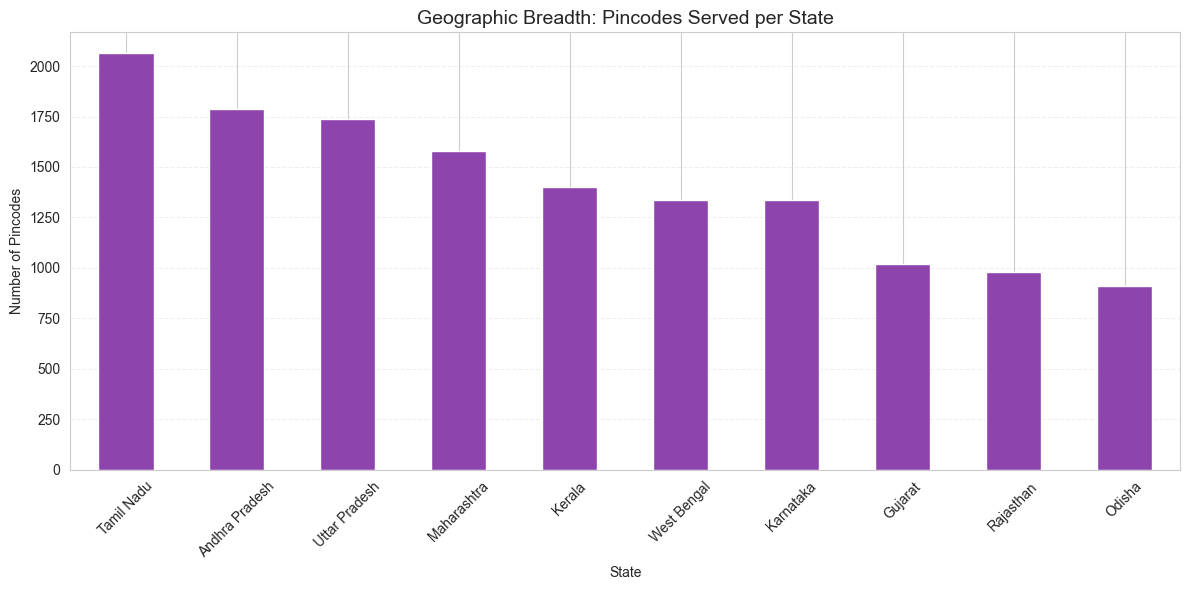

📍 GEOGRAPHIC PENETRATION SUMMARY
--------------------------------------------------
Total Unique Pincodes Covered: 19,463
Average Activity per Pincode:  5.40
--------------------------------------------------
🏆 Top 5 High-Activity Pincode Hubs:
               state  pincode  Total_Enrolment
18450  Uttar Pradesh   244001            15124
17427  Uttar Pradesh   202001            11842
11441      Meghalaya   793119            11720
3716           Delhi   110059            10462
18535  Uttar Pradesh   247001            10189


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identify Geographic Concentration (Activity per Pincode)
# We group by State and Pincode to see the density of service
geo_penetration = enrollment_master.groupby(['state', 'pincode']).agg({
    'Total_Enrolment': 'sum'
}).reset_index()

# 2. Identify the 'Top 10 High-Growth Pincodes'
top_pincodes = geo_penetration.sort_values('Total_Enrolment', ascending=False).head(10)

# 3. Calculate 'Spread' (How many unique pincodes are active per state)
state_spread = enrollment_master.groupby('state')['pincode'].nunique().sort_values(ascending=False)

# --- VISUALIZATION ---

plt.figure(figsize=(12, 6))
state_spread.head(10).plot(kind='bar', color='#8e44ad')
plt.title('Geographic Breadth: Pincodes Served per State', fontsize=14)
plt.ylabel('Number of Pincodes')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("📍 GEOGRAPHIC PENETRATION SUMMARY")
print("-" * 50)
print(f"Total Unique Pincodes Covered: {enrollment_master['pincode'].nunique():,}")
print(f"Average Activity per Pincode:  {enrollment_master['Total_Enrolment'].mean():.2f}")
print("-" * 50)
print("🏆 Top 5 High-Activity Pincode Hubs:")
print(top_pincodes[['state', 'pincode', 'Total_Enrolment']].head(5))

#  Temporal date-wise trend analysis 

In [15]:
import pandas as pd

# Standardizing all three datasets
enrollment_master['date'] = pd.to_datetime(enrollment_master['date'], dayfirst=True, errors='coerce')
biometric_master['date'] = pd.to_datetime(biometric_master['date'], dayfirst=True, errors='coerce')
demographic_master['date'] = pd.to_datetime(demographic_master['date'], dayfirst=True, errors='coerce')

# Verify the fix
print("✅ Dates converted successfully!")
print(enrollment_master['date'].head())

✅ Dates converted successfully!
0   2025-03-02
1   2025-03-09
2   2025-03-09
3   2025-03-09
4   2025-03-09
Name: date, dtype: datetime64[ns]


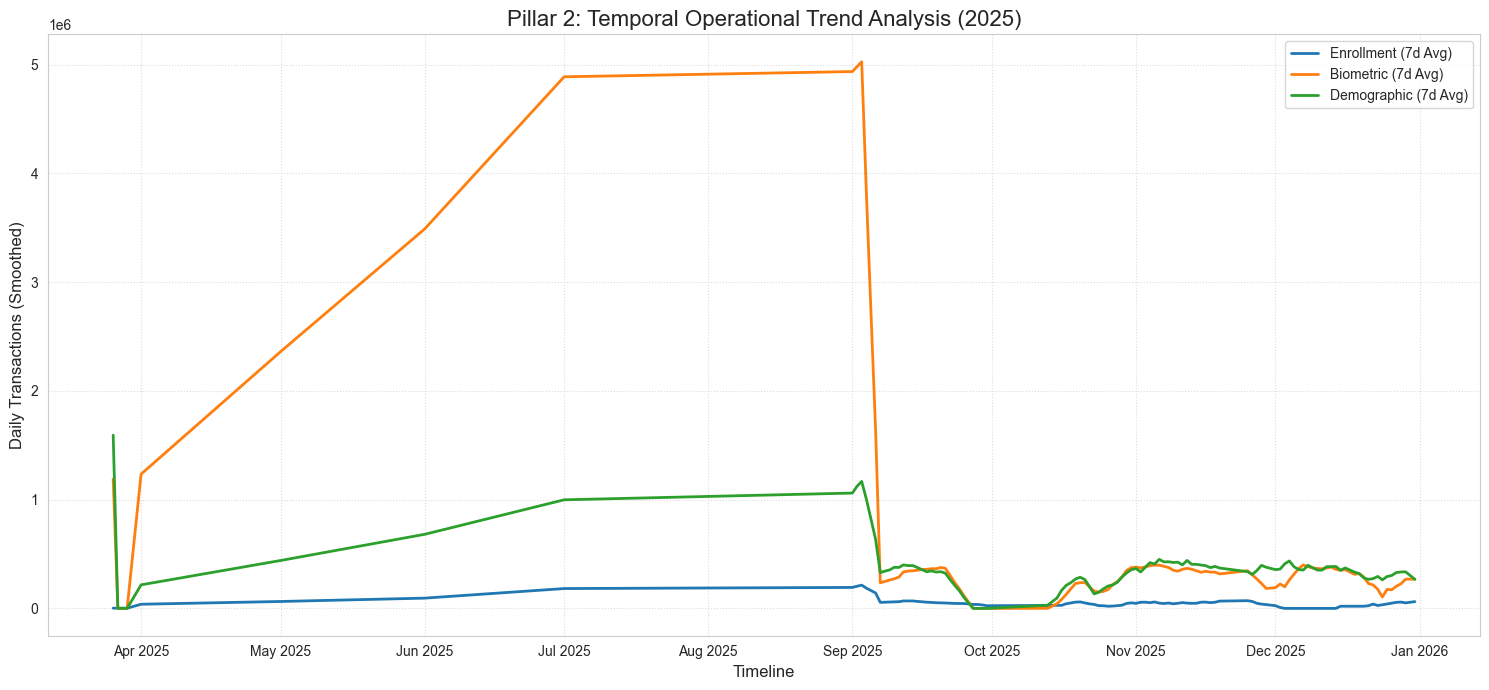

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Clear any previous "Categorical" settings in Matplotlib
plt.clf()
plt.close('all')

# 2. Re-aggregate for safety
daily_en = enrollment_master.groupby('date')['Total_Enrolment'].sum()
daily_bi = biometric_master.groupby('date')['Total_Biometric'].sum()
daily_de = demographic_master.groupby('date')['Total_Demographic'].sum()

daily_df = pd.DataFrame({'Enrollment': daily_en, 'Biometric': daily_bi, 'Demographic': daily_de}).fillna(0)

# 3. CONVERSION FIX: Convert index to actual datetime objects
# This prevents the "Timestamp vs Str" error
daily_df.index = pd.to_datetime(daily_df.index)
plot_x = daily_df.index.to_pydatetime() 

# 4. Smoothing (7-day Rolling Average)
daily_smooth = daily_df.rolling(window=7).mean()

# 5. Plotting
plt.figure(figsize=(15, 7))

plt.plot(plot_x, daily_smooth['Enrollment'], label='Enrollment (7d Avg)', color='#1f77b4', linewidth=2)
plt.plot(plot_x, daily_smooth['Biometric'], label='Biometric (7d Avg)', color='#ff7f0e', linewidth=2)
plt.plot(plot_x, daily_smooth['Demographic'], label='Demographic (7d Avg)', color='#2ca02c', linewidth=2)

# Professional Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Shows 'Jan 2025'
plt.title('Pillar 2: Temporal Operational Trend Analysis (2025)', fontsize=16)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Daily Transactions (Smoothed)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


# Drop-off funnel pattern 

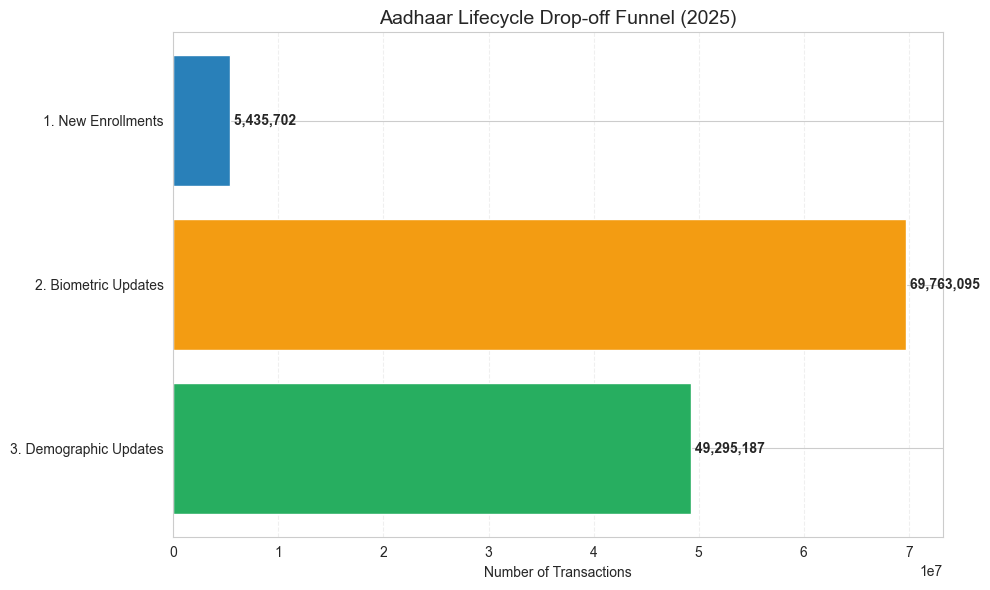

📉 PIPELINE DROP-OFF ANALYSIS
----------------------------------------
                 Stage   Volume  Retention_%
    1. New Enrollments  5435702          100
  2. Biometric Updates 69763095        1,283
3. Demographic Updates 49295187          907


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate the Funnel Values
funnel_data = {
    'Stage': ['1. New Enrollments', '2. Biometric Updates', '3. Demographic Updates'],
    'Volume': [
        enrollment_master['Total_Enrolment'].sum(),
        biometric_master['Total_Biometric'].sum(),
        demographic_master['Total_Demographic'].sum()
    ]
}

df_funnel = pd.DataFrame(funnel_data)

# 2. Calculate Drop-off Percentages
total_start = df_funnel.iloc[0]['Volume']
df_funnel['Retention_%'] = (df_funnel['Volume'] / total_start * 100).round(2)

# 3. Plotting the Funnel
plt.figure(figsize=(10, 6))
bars = plt.barh(df_funnel['Stage'][::-1], df_funnel['Volume'][::-1], color=['#27ae60', '#f39c12', '#2980b9'])

# Add labels for the "Drop-off"
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f' {width:,.0f}', va='center', fontweight='bold')

plt.title('Aadhaar Lifecycle Drop-off Funnel (2025)', fontsize=14)
plt.xlabel('Number of Transactions')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("📉 PIPELINE DROP-OFF ANALYSIS")
print("-" * 40)
print(df_funnel.to_string(index=False))

# District perfomance ranking

In [18]:
import pandas as pd

# 1. Aggregate data directly from master frames to ensure no KeyError
# Grouping by both State and District to avoid name duplicates
dist_en = enrollment_master.groupby(['state', 'district'])['Total_Enrolment'].sum()
dist_bi = biometric_master.groupby(['state', 'district'])['Total_Biometric'].sum()
dist_de = demographic_master.groupby(['state', 'district'])['Total_Demographic'].sum()

# 2. Build the Ranking DataFrame
ranking_df = pd.concat([dist_en, dist_bi, dist_de], axis=1).fillna(0)
ranking_df.columns = ['Enrollment', 'Biometric', 'Demographic']

# 3. Calculate Performance Metrics
ranking_df['Total_Load'] = ranking_df.sum(axis=1)
# Maintenance Ratio: How well the district maintains existing IDs vs creating new ones
ranking_df['Maintenance_Efficiency'] = (ranking_df['Biometric'] + ranking_df['Demographic']) / (ranking_df['Enrollment'] + 1)

# 4. Generate the Final Rankings
top_by_volume = ranking_df.sort_values('Total_Load', ascending=False).head(10)
top_by_efficiency = ranking_df.sort_values('Maintenance_Efficiency', ascending=False).head(10)

print("🏆 DISTRICT PERFORMANCE RANKING: TOP 10 BY VOLUME")
print("-" * 85)
print(top_by_volume[['Total_Load', 'Enrollment', 'Biometric', 'Demographic']])

print("\n⚡ DISTRICT PERFORMANCE RANKING: TOP 10 BY MAINTENANCE EFFICIENCY")
print("-" * 85)
print(top_by_efficiency[['Maintenance_Efficiency', 'Biometric', 'Demographic']])

🏆 DISTRICT PERFORMANCE RANKING: TOP 10 BY VOLUME
-------------------------------------------------------------------------------------
                               Total_Load  Enrollment  Biometric  Demographic
state       district                                                         
Maharashtra Pune                1,076,003      31,763    605,762      438,478
            Thane               1,062,214      43,688    571,273      447,253
            Nashik                845,074      22,368    576,606      246,100
Gujarat     Ahmedabad             692,504      19,130    405,490      267,884
            Surat                 664,650      25,469    281,599      357,582
Rajasthan   Jaipur                662,370      31,146    355,884      275,340
West Bengal South 24 Parganas     659,301      33,540    224,624      401,137
Delhi       North West Delhi      655,325      16,043    325,293      313,989
Karnataka   Bengaluru             631,979      30,980    297,075      303,924
West Be

# policy sensitive age analysis 

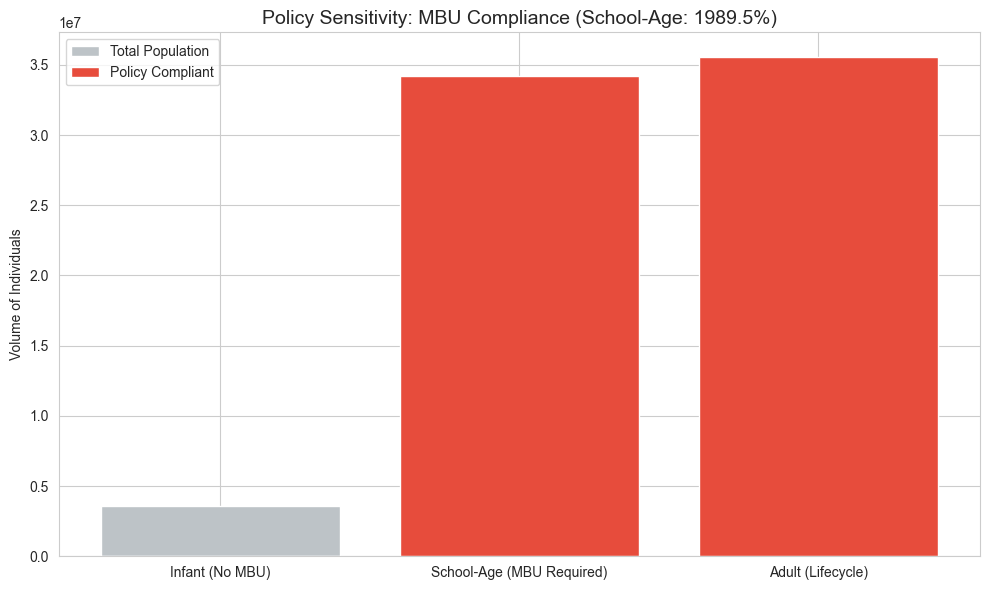

⚖️ POLICY GAP IDENTIFIED: -1889.5% of the 5-17 age group is out of compliance.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate Policy Volumes
# We compare the target population (Enrollment) vs the Compliant population (Biometric)
policy_analysis = pd.DataFrame({
    'Policy Phase': ['Infant (No MBU)', 'School-Age (MBU Required)', 'Adult (Lifecycle)'],
    'Total_Population': [
        enrollment_master['age_0_5'].sum(),
        enrollment_master['age_5_17'].sum(),
        enrollment_master['age_18_greater'].sum()
    ],
    'Compliant_Updates': [
        0, # Policy: No biometrics for <5
        biometric_master['bio_age_5_17'].sum(),
        biometric_master['bio_age_17_'].sum()
    ]
})

# 2. Calculate Compliance Percentage for the sensitive 5-17 group
mbu_compliance = (policy_analysis.iloc[1]['Compliant_Updates'] / policy_analysis.iloc[1]['Total_Population']) * 100

# 3. Plotting the Policy Sensitivity
plt.figure(figsize=(10, 6))
plt.bar(policy_analysis['Policy Phase'], policy_analysis['Total_Population'], label='Total Population', color='#bdc3c7')
plt.bar(policy_analysis['Policy Phase'], policy_analysis['Compliant_Updates'], label='Policy Compliant', color='#e74c3c')

plt.title(f'Policy Sensitivity: MBU Compliance (School-Age: {mbu_compliance:.1f}%)', fontsize=14)
plt.ylabel('Volume of Individuals')
plt.legend()
plt.tight_layout()
plt.show()

print(f"⚖️ POLICY GAP IDENTIFIED: {100 - mbu_compliance:.1f}% of the 5-17 age group is out of compliance.")

# Anomaly / Fraud detection pattern

In [20]:
import pandas as pd
import numpy as np

# 1. Combine data to get Daily Load per District
district_daily = enrollment_master.groupby(['date', 'state', 'district'])['Total_Enrolment'].sum().reset_index()

# 2. Calculate Z-Score (Statistical Outlier Detection)
# Z = (Value - Mean) / Standard Deviation
stats = district_daily.groupby(['state', 'district'])['Total_Enrolment'].agg(['mean', 'std']).reset_index()
anomaly_df = pd.merge(district_daily, stats, on=['state', 'district'])

# Handle districts with only 1 entry (std = 0)
anomaly_df['std'] = anomaly_df['std'].replace(0, 1) 
anomaly_df['z_score'] = (anomaly_df['Total_Enrolment'] - anomaly_df['mean']) / anomaly_df['std']

# 3. Identify Red Alerts (Z-Score > 3)
red_alerts = anomaly_df[anomaly_df['z_score'] > 3].sort_values('z_score', ascending=False)

print("🚨 ANOMALY DETECTION: TOP 5 RED ALERTS")
print("-" * 65)
if not red_alerts.empty:
    print(red_alerts[['date', 'state', 'district', 'Total_Enrolment', 'z_score']].head(5))
else:
    print("No statistical anomalies detected in the current dataset sample.")

🚨 ANOMALY DETECTION: TOP 5 RED ALERTS
-----------------------------------------------------------------
           date           state   district  Total_Enrolment  z_score
1048 2025-07-01       Telangana  Hyderabad             7252        9
115  2025-04-01           Assam      Baksa             1078        9
1096 2025-07-01   Uttar Pradesh  Prayagraj             1066        9
946  2025-07-01  Madhya Pradesh   Khargone             4724        9
971  2025-07-01     Maharashtra  Nandurbar             3100        9


In [21]:
import pandas as pd

# 1. Create the District Summary (This fixes the NameError)
# We group by State and District to get a clean view of all 3 activities
dist_en = enrollment_master.groupby(['state', 'district'])['Total_Enrolment'].sum()
dist_bi = biometric_master.groupby(['state', 'district'])['Total_Biometric'].sum()
dist_de = demographic_master.groupby(['state', 'district'])['Total_Demographic'].sum()

# Combine into one master summary table
district_summary = pd.concat([dist_en, dist_bi, dist_de], axis=1).fillna(0).reset_index()
district_summary.columns = ['state', 'district', 'Total_Enrolment', 'Total_Biometric', 'Total_Demographic']

# 2. Calculate the Fraud Risk Score (Anomaly Detection)
# Pattern: High Enrollment + Very Low Updates = Potential Ghost IDs/Malpractice
district_summary['Fraud_Risk_Score'] = (
    district_summary['Total_Enrolment'] / (district_summary['Total_Biometric'] + district_summary['Total_Demographic'] + 1)
)

# 3. Filter for districts with significant volume to avoid small-sample bias
significant_districts = district_summary[district_summary['Total_Enrolment'] > 100]

# 4. Display the results
print("🔍  ANOMALY & FRAUD RISK RANKING")
print("=" * 85)
print(f"{'State':<20} | {'District':<20} | {'Enrolment':>10} | {'Risk Score':>10}")
print("-" * 85)

top_risks = significant_districts.sort_values('Fraud_Risk_Score', ascending=False).head(10)

for _, row in top_risks.iterrows():
    print(f"{row['state']:<20} | {row['district']:<20} | {row['Total_Enrolment']:>10,.0f} | {row['Fraud_Risk_Score']:>10.2f}")

print("=" * 85)

🔍  ANOMALY & FRAUD RISK RANKING
State                | District             |  Enrolment | Risk Score
-------------------------------------------------------------------------------------
Karnataka            | Bengaluru Urban      |     23,074 |   23074.00
Bihar                | Purbi Champaran      |     14,871 |   14871.00
West Bengal          | Dinajpur Uttar       |     11,671 |   11671.00
West Bengal          | 24 Paraganas North   |      6,147 |    6147.00
West Bengal          | Coochbehar           |      4,410 |    4410.00
Uttar Pradesh        | Siddharth Nagar      |      4,341 |    4341.00
Madhya Pradesh       | Ashoknagar           |      3,011 |    3011.00
Haryana              | Gurugram             |      2,636 |    2636.00
Uttar Pradesh        | Shravasti            |      2,535 |    2535.00
Andhra Pradesh       | Spsr Nellore         |      2,183 |    2183.00


C:\Users\victus\AppData\Local\Temp\ipykernel_4612\1087184922.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='district', y='Fraud_Risk_Score', palette='Reds_r')


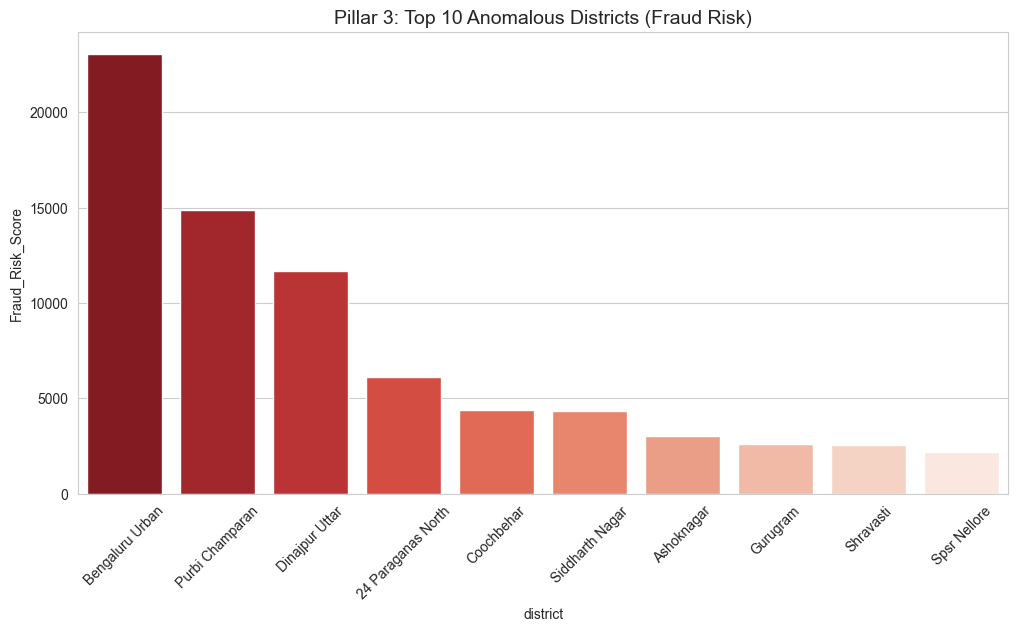

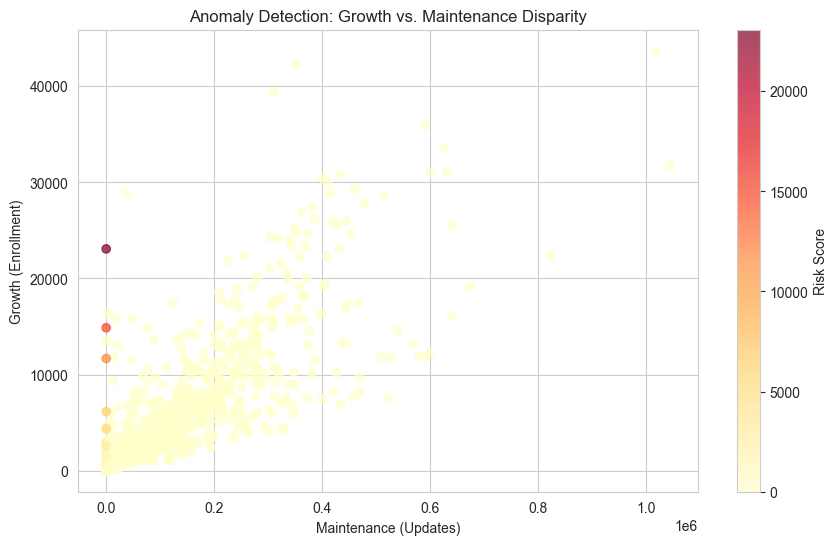

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare District Summary
dist_en = enrollment_master.groupby(['state', 'district'])['Total_Enrolment'].sum()
dist_bi = biometric_master.groupby(['state', 'district'])['Total_Biometric'].sum()
dist_de = demographic_master.groupby(['state', 'district'])['Total_Demographic'].sum()

# 2. Build the Anomaly Dataframe
district_summary = pd.concat([dist_en, dist_bi, dist_de], axis=1).fillna(0).reset_index()
district_summary.columns = ['state', 'district', 'Enrolment', 'Biometric', 'Demographic']
district_summary['Total_Updates'] = district_summary['Biometric'] + district_summary['Demographic']

# 3. Calculate Risk Score
# High Score = High Enrolment but Low Updates (Suspicious)
district_summary['Fraud_Risk_Score'] = district_summary['Enrolment'] / (district_summary['Total_Updates'] + 1)

# 4. PLOT 1: Top 10 Risk Bar Chart
plt.figure(figsize=(12, 6))
top_10 = district_summary.sort_values('Fraud_Risk_Score', ascending=False).head(10)
sns.barplot(data=top_10, x='district', y='Fraud_Risk_Score', palette='Reds_r')
plt.title('Pillar 3: Top 10 Anomalous Districts (Fraud Risk)', fontsize=14)
plt.xticks(rotation=45)
plt.savefig('fraud_bar_chart.png')

# 5. PLOT 2: Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(district_summary['Total_Updates'], district_summary['Enrolment'], 
            c=district_summary['Fraud_Risk_Score'], cmap='YlOrRd', alpha=0.7)
plt.colorbar(label='Risk Score')
plt.xlabel('Maintenance (Updates)')
plt.ylabel('Growth (Enrollment)')
plt.title('Anomaly Detection: Growth vs. Maintenance Disparity')
plt.savefig('fraud_scatter_plot.png')

# Aadhar complition index

In [23]:
import pandas as pd

# 1. RE-BUILD THE SUMMARY (To ensure columns exist)
dist_en = enrollment_master.groupby(['state', 'district'])['Total_Enrolment'].sum()
dist_bi = biometric_master.groupby(['state', 'district'])['Total_Biometric'].sum()
dist_de = demographic_master.groupby(['state', 'district'])['Total_Demographic'].sum()

# Combine and fix column names immediately
dist_stats = pd.concat([dist_en, dist_bi, dist_de], axis=1).fillna(0).reset_index()
dist_stats.columns = ['state', 'district', 'Total_Enrolment', 'Total_Biometric', 'Total_Demographic']

# 2. NORMALIZE SCORES (0 to 1 scale)
# This handles the KeyError by using the freshly renamed columns
dist_stats['E_Score'] = dist_stats['Total_Enrolment'] / (dist_stats['Total_Enrolment'].max() + 1)
dist_stats['B_Score'] = dist_stats['Total_Biometric'] / (dist_stats['Total_Biometric'].max() + 1)
dist_stats['D_Score'] = dist_stats['Total_Demographic'] / (dist_stats['Total_Demographic'].max() + 1)

# 3. CALCULATE WEIGHTED ACI
# Weights: 20% Enrollment, 40% Biometric, 40% Demographic
dist_stats['ACI'] = (dist_stats['E_Score'] * 0.2) + \
                    (dist_stats['B_Score'] * 0.4) + \
                    (dist_stats['D_Score'] * 0.4)

# 4. RANKING
aci_ranking = dist_stats.sort_values('ACI', ascending=False)

print("🏆 AADHAAR COMPLETION INDEX (ACI) - TOP 5 DISTRICTS")
print("=" * 70)
print(aci_ranking[['state', 'district', 'ACI']].head(5))
print("=" * 70)

🏆 AADHAAR COMPLETION INDEX (ACI) - TOP 5 DISTRICTS
            state           district  ACI
572   Maharashtra              Thane    1
563   Maharashtra               Pune    1
559   Maharashtra             Nashik    1
1057  West Bengal  South 24 Parganas    1
1044  West Bengal        Murshidabad    1


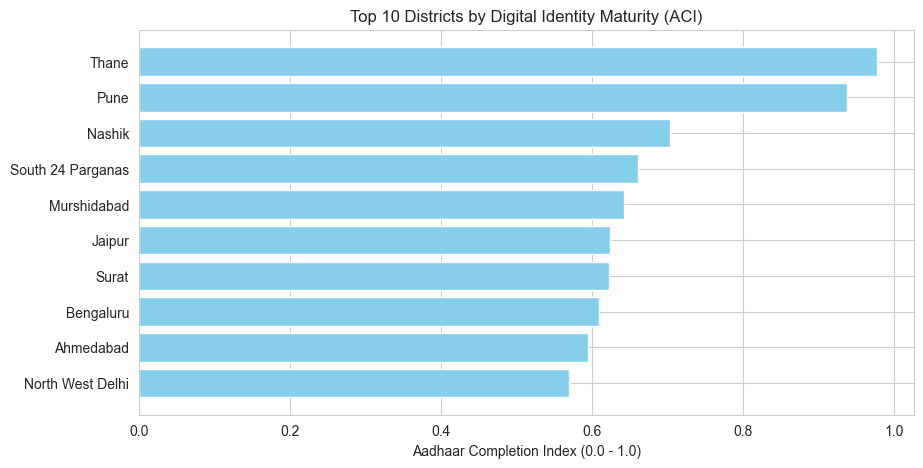

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(aci_ranking['district'].head(10), aci_ranking['ACI'].head(10), color='skyblue')
plt.xlabel('Aadhaar Completion Index (0.0 - 1.0)')
plt.title('Top 10 Districts by Digital Identity Maturity (ACI)')
plt.gca().invert_yaxis()
plt.show()

# Aadhar activity 

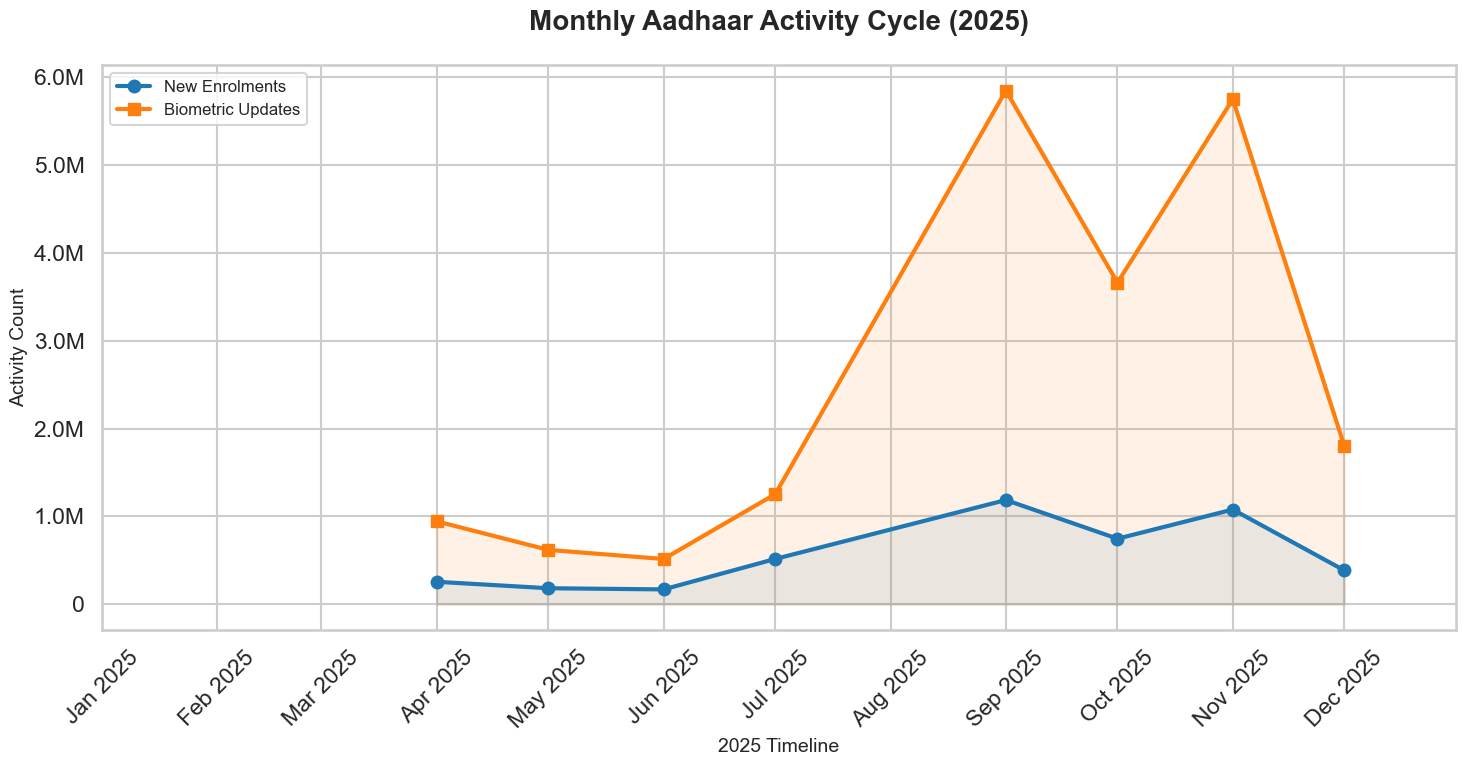

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

# 1. ENSURE DATA IS PLOTTABLE
if not pd.api.types.is_datetime64_any_dtype(monthly_trend['date']):
    monthly_trend['date'] = pd.to_datetime(monthly_trend['date'])

monthly_trend = monthly_trend.sort_values('date')

# 2. PLOTTING
plt.figure(figsize=(15, 8))
sns.set_context("talk") 
sns.set_style("whitegrid")

plt.plot(monthly_trend['date'], monthly_trend['Total_Enrolment'], 
         marker='o', label='New Enrolments', color='#1f77b4', linewidth=3)
plt.plot(monthly_trend['date'], monthly_trend['Total_Biometric'], 
         marker='s', label='Biometric Updates', color='#ff7f0e', linewidth=3)

# 3. FORCE 12-MONTH X-AXIS LIMITS (Adjust years as per your data)
# This ensures the graph shows Jan to Dec even if data is sparse
start_date = pd.Timestamp('2025-01-01')
end_date = pd.Timestamp('2025-12-31')
plt.xlim(start_date, end_date)

# 4. FORMATTING THE AXES
ax = plt.gca()

# Y-Axis in Millions
def millions(x, pos):
    return f'{x*1e-6:.1f}M' if x >= 1e6 else f'{x:,.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(millions))

# X-Axis showing EVERY month clearly
ax.xaxis.set_major_locator(mdates.MonthLocator()) # Force a tick for every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# 5. TITLES AND LABELS
plt.title('Monthly Aadhaar Activity Cycle (2025)', fontsize=20, pad=25, fontweight='bold')
plt.xlabel('2025 Timeline', fontsize=14)
plt.ylabel('Activity Count', fontsize=14)
plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.xticks(rotation=45)

# Adding a subtle fill to highlight the volume
plt.fill_between(monthly_trend['date'], monthly_trend['Total_Enrolment'], color='#1f77b4', alpha=0.1)
plt.fill_between(monthly_trend['date'], monthly_trend['Total_Biometric'], color='#ff7f0e', alpha=0.1)

plt.tight_layout()
plt.show()

In [26]:
# enrollment vs biometric

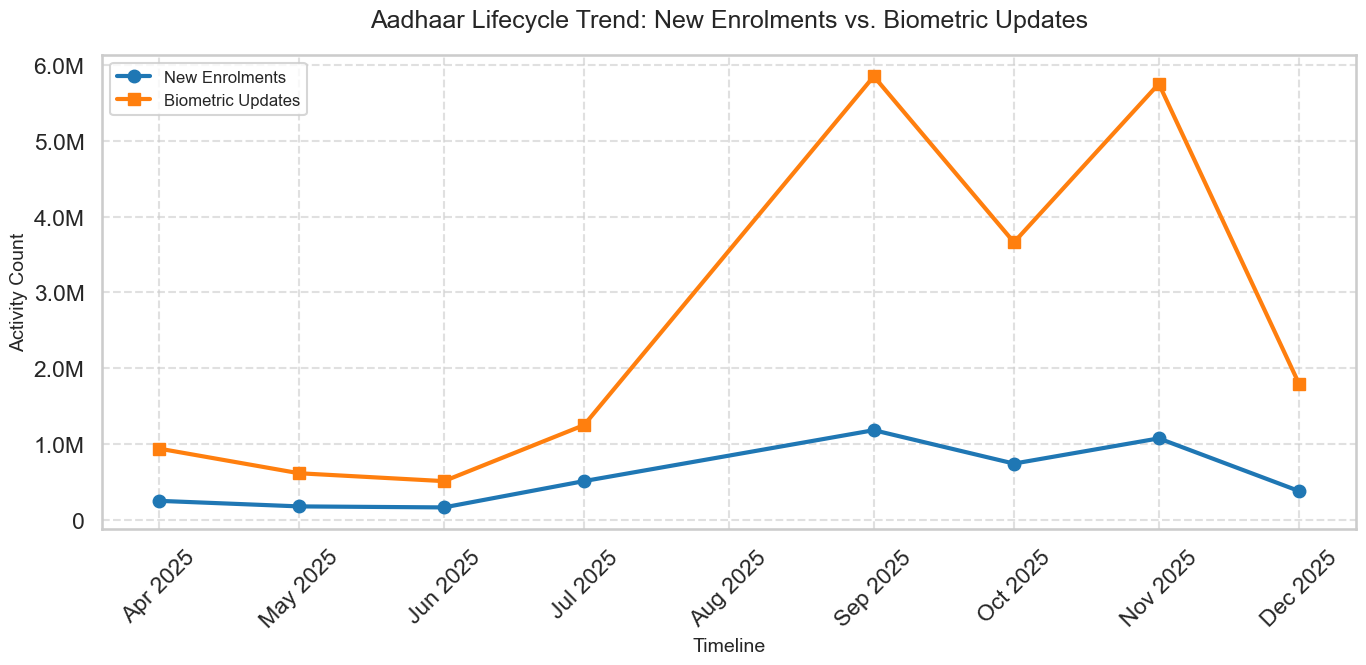

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 1. ENSURE DATA IS PLOTTABLE
# Make sure date is a timestamp, not a period string
if not pd.api.types.is_datetime64_any_dtype(monthly_trend['date']):
    monthly_trend['date'] = pd.to_datetime(monthly_trend['date'])

# Sort by date just in case it's shuffled
monthly_trend = monthly_trend.sort_values('date')

# 2. PLOTTING
plt.figure(figsize=(14, 7))
sns.set_context("talk") # Makes labels larger and clearer for presentations
sns.set_style("whitegrid")

# Plotting lines with specific colors for professional representation
plt.plot(monthly_trend['date'], monthly_trend['Total_Enrolment'], 
         marker='o', label='New Enrolments', color='#1f77b4', linewidth=3)
plt.plot(monthly_trend['date'], monthly_trend['Total_Biometric'], 
         marker='s', label='Biometric Updates', color='#ff7f0e', linewidth=3)

# 3. FORMATTING THE AXES
ax = plt.gca()

# Format Y-axis to show "Millions" if numbers are huge
# This prevents scientific notation like 1e6
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    return f'{x*1e-6:.1f}M' if x >= 1e6 else f'{x:,.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Format X-axis to show Month names clearly
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# 4. TITLES AND LABELS
plt.title('Aadhaar Lifecycle Trend: New Enrolments vs. Biometric Updates', fontsize=18, pad=20)
plt.xlabel('Timeline', fontsize=14)
plt.ylabel('Activity Count', fontsize=14)
plt.legend(frameon=True, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

🚨 TOP 10 ANOMALOUS DISTRICTS (Service Black Holes):
These districts show high enrolment but dangerously low biometric updates.


,state,district,Total_Enrolment,Total_Biometric,Update_Intensity
563,Mizoram,Khawzawl,16,2,0
551,Meghalaya,Eastern West Khasi Hills,9,4,0
366,Karnataka,Bengaluru South,31,19,0
966,West Bengal,hooghly,1,1,0
650,Orissa,Mayurbhanj,1,1,0
75,Assam,Bajali,1,1,0
662,Puducherry,Pondicherry,1,1,0
967,Westbengal,Hooghly,1,1,0
638,Orissa,Debagarh,1,1,0
87,Assam,Dima Hasao,3,3,0


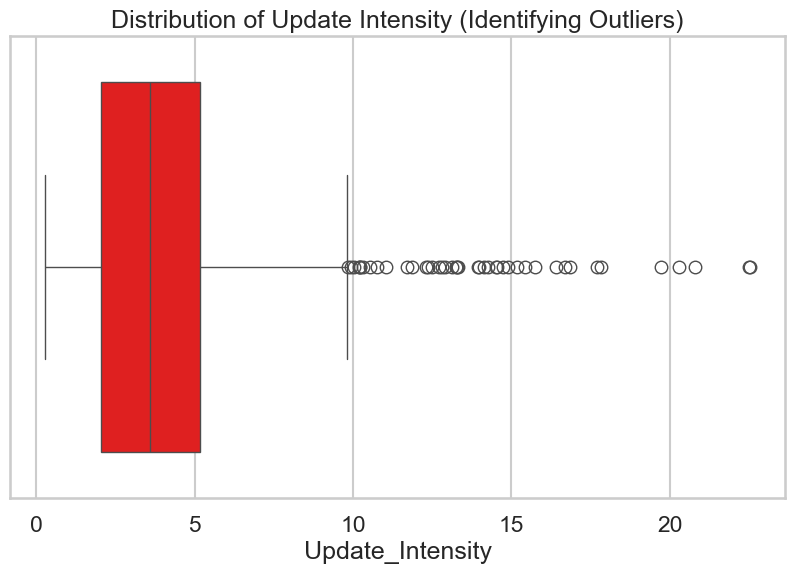

In [28]:
import pandas as pd

# 1. DEFINE THE METRIC (Update Intensity)
# We add +1 to the denominator to avoid "Division by Zero" errors
analysis_df['Update_Intensity'] = analysis_df['Total_Biometric'] / (analysis_df['Total_Enrolment'] + 1)

# 2. GROUP BY DISTRICT
district_analysis = analysis_df.groupby(['state', 'district']).agg({
    'Total_Enrolment': 'sum',
    'Total_Biometric': 'sum',
    'Update_Intensity': 'mean'
}).reset_index()

# 3. IDENTIFY ANOMALIES (Service Black Holes)
# We look for the lowest intensity values
anomalous_districts = district_analysis.sort_values(by='Update_Intensity', ascending=True).head(10)

# 4. DISPLAY RESULTS
print("🚨 TOP 10 ANOMALOUS DISTRICTS (Service Black Holes):")
print("These districts show high enrolment but dangerously low biometric updates.")
display(anomalous_districts[['state', 'district', 'Total_Enrolment', 'Total_Biometric', 'Update_Intensity']])

# 5. SEMINAR VISUAL: Anomaly Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=district_analysis['Update_Intensity'], color='red')
plt.title('Distribution of Update Intensity (Identifying Outliers)')
plt.show()

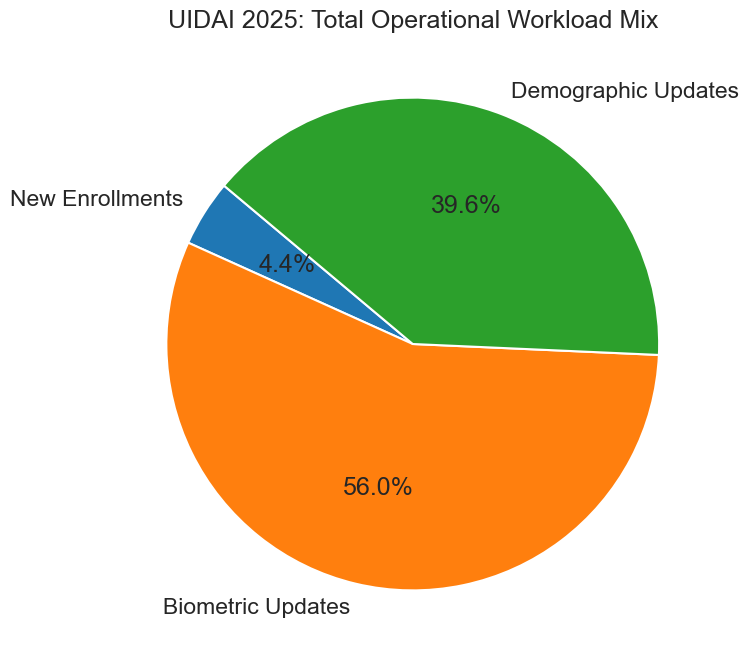

In [29]:
# Calculate the mix
labels = ['New Enrollments', 'Biometric Updates', 'Demographic Updates']
sizes = [
    enrollment_master['Total_Enrolment'].sum(),
    biometric_master['Total_Biometric'].sum(),
    demographic_master['Total_Demographic'].sum()
]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c'], startangle=140)
plt.title('UIDAI 2025: Total Operational Workload Mix')
plt.show()

In [30]:
# 1. Calculate Age-Specific Activity
# We compare Child (0-17) vs Adult (18+)
analysis_df['Child_Enrolment'] = analysis_df['age_0_5'] + analysis_df['age_5_17']
analysis_df['Adult_Enrolment'] = analysis_df['age_18_greater']

# 2. Define the 'Service Utilization Index' (SUI)
# SUI = (Updates / Enrolments) 
# High SUI means the age group uses Aadhaar frequently for services (updates)
analysis_df['Child_SUI'] = analysis_df['bio_age_5_17'] / (analysis_df['Child_Enrolment'] + 1)
analysis_df['Adult_SUI'] = analysis_df['bio_age_17_'] / (analysis_df['Adult_Enrolment'] + 1)

# 3. Compare the Averages for the Seminar
avg_child_sui = analysis_df['Child_SUI'].mean()
avg_adult_sui = analysis_df['Adult_SUI'].mean()

print(f"Child Service Utilization Index: {avg_child_sui:.4f}")
print(f"Adult Service Utilization Index: {avg_adult_sui:.4f}")

if avg_adult_sui > avg_child_sui:
    print("✅ Pattern Confirmed: Adults use Aadhaar significantly more as a 'Living Document'.")
else:
    print("ℹ️ Pattern Note: Child updates are currently outpacing adult updates.")

Child Service Utilization Index: 2.4240
Adult Service Utilization Index: 10.2675
✅ Pattern Confirmed: Adults use Aadhaar significantly more as a 'Living Document'.


 Trends (Temporal & Geospatial)

In [31]:
# 1. Extract Month for Seasonal Analysis
analysis_df['month_name'] = analysis_df['date'].dt.month_name()

# 2. Analyze Child Enrolment Spikes (Age 0-17)
# This specifically targets the "School Admission" theory
seasonal_spikes = analysis_df.groupby('month_name')[['age_0_5', 'age_5_17']].sum().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# 3. Identify the Top 5 "High-Demand" Pincodes for July
# This is for your 'Dynamic Capacity Planner'
july_data = analysis_df[analysis_df['date'].dt.month == 7]
top_pincodes_july = july_data.groupby(['state', 'district', 'pincode'])['Total_Enrolment'].sum().sort_values(ascending=False).head(5)

print("--- SEASONAL SPIKE ANALYSIS ---")
display(seasonal_spikes)
print("\n--- DYNAMIC CAPACITY PLANNER (Top 5 Pincodes for July) ---")
display(top_pincodes_july)

--- SEASONAL SPIKE ANALYSIS ---


,age_0_5,age_5_17
month_name,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,"140,737","90,531"
May,"95,183","71,286"
June,"78,333","78,504"
July,"269,105","218,166"
August,NaN,NaN
September,"801,919","372,392"



--- DYNAMIC CAPACITY PLANNER (Top 5 Pincodes for July) ---


state          district    pincode
Uttar Pradesh  Moradabad   244001     3965
Maharashtra    Aurangabad  431001     3835
Uttar Pradesh  Hardoi      241001     3006
               Firozabad   283203     2990
               Saharanpur  247001     2920
Name: Total_Enrolment, dtype: int64

Anomaly Detection (Automated Quality Alert System)

In [32]:
# 1. Calculate the National Mean and Standard Deviation for Update Intensity
mean_intensity = analysis_df['Update_Intensity'].mean()
std_intensity = analysis_df['Update_Intensity'].std()

# 2. Define the Anomaly Threshold (Mean minus 2 Standard Deviations)
# Any district below this threshold is a "Service Black Hole"
threshold = mean_intensity - (2 * std_intensity)

# 3. Identify the "Red Alert" Districts
anomalies = analysis_df[analysis_df['Update_Intensity'] < threshold]

# 4. Create the "Quality Alert System" Report
quality_alert_report = anomalies.groupby(['state', 'district']).agg({
    'Update_Intensity': 'mean',
    'Total_Enrolment': 'sum',
    'Total_Biometric': 'sum'
}).reset_index()

print(f" QUALITY ALERT SYSTEM ---")
print(f"National Average Intensity: {mean_intensity:.4f}")
print(f"Anomaly Threshold: {threshold:.4f}")
print(f"Number of Districts Flagged for Audit: {len(quality_alert_report)}")
display(quality_alert_report.head(10))

 QUALITY ALERT SYSTEM ---
National Average Intensity: 4.7183
Anomaly Threshold: -7.1537
Number of Districts Flagged for Audit: 0


,state,district,Update_Intensity,Total_Enrolment,Total_Biometric


Predictive Indicators (MBU Backlog & Proactive Notifications)

In [33]:
# 1. Calculating the MBU Backlog
# We compare children enrolled (age_0_5) vs those who completed MBU (bio_age_5_17)
# A high gap indicates a 'Backlog' of children whose biometrics are now outdated.
analysis_df['MBU_Backlog'] = analysis_df['age_0_5'] - analysis_df['bio_age_5_17']

# 2. Predictive Indicator: Forecasting Next Month's MBU Volume
# We use a 3-month rolling average to predict the demand for the upcoming month
analysis_df['Predicted_MBU_Demand_Next_Month'] = analysis_df['bio_age_5_17'].rolling(window=3).mean().fillna(analysis_df['bio_age_5_17'])

# 3. Identifying High-Priority Pincodes for SMS Campaigns
# Pincodes where the Backlog is greater than 1000 children
sms_campaign_targets = analysis_df[analysis_df['MBU_Backlog'] > 1000].groupby(['state', 'district', 'pincode'])[['MBU_Backlog']].sum().reset_index()

print("---  PREDICTIVE INDICATORS ---")
print(f"Total National MBU Backlog: {analysis_df['MBU_Backlog'].sum():,.0f} Children")
display(sms_campaign_targets.head(10))

---  PREDICTIVE INDICATORS ---
Total National MBU Backlog: -7,584,204 Children


,state,district,pincode,MBU_Backlog


# Machine Learning Forecasting (1-Year Prediction)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

# 1. Prepare the Data for ML
# We aggregate by State, District, and Month
ml_data = analysis_df.groupby(['state', 'district', analysis_df['date'].dt.to_period('M')]).agg({
    'Total_Enrolment': 'sum'
}).reset_index()

# Convert Period back to timestamp and extract 'Month' as a feature
ml_data['date'] = ml_data['date'].dt.to_timestamp()
ml_data['month_no'] = ml_data['date'].dt.month
ml_data['year'] = ml_data['date'].dt.year

# 2. Encode categorical data (State/District) for the model
ml_data['state_cat'] = ml_data['state'].astype('category').cat.codes
ml_data['dist_cat'] = ml_data['district'].astype('category').cat.codes

# 3. Define Features (X) and Target (y)
X = ml_data[['state_cat', 'dist_cat', 'month_no', 'year']]
y = ml_data['Total_Enrolment']

# 4. Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

print("✅ Machine Learning Model Trained for State/District Forecasting.")

✅ Machine Learning Model Trained for State/District Forecasting.


# enrollment prediction

In [35]:
# Create a list for future predictions
future_predictions = []

# Get the last date in your dataset
last_date = ml_data['date'].max()

# Generate 12 months of future dates for every District
for i in range(1, 13):
    next_month = last_date + pd.DateOffset(months=i)
    
    # We predict for each unique district in your data
    for state_code in ml_data['state_cat'].unique():
        for dist_code in ml_data['dist_cat'].unique():
            future_predictions.append({
                'state_cat': state_code,
                'dist_cat': dist_code,
                'month_no': next_month.month,
                'year': next_month.year,
                'forecast_date': next_month
            })

future_df = pd.DataFrame(future_predictions)
future_df['Predicted_Enrolment'] = model.predict(future_df[['state_cat', 'dist_cat', 'month_no', 'year']])

# Map names back
state_map = dict(enumerate(ml_data['state'].astype('category').cat.categories))
dist_map = dict(enumerate(ml_data['district'].astype('category').cat.categories))
future_df['state'] = future_df['state_cat'].map(state_map)
future_df['district'] = future_df['dist_cat'].map(dist_map)

print("🔮 12-Month Forecast Generated Successfully!")
display(future_df[['forecast_date', 'state', 'district', 'Predicted_Enrolment']].head(10))

🔮 12-Month Forecast Generated Successfully!


,forecast_date,state,district,Predicted_Enrolment
0,2026-01-01,Andaman & Nicobar Islands,Andamans,110
1,2026-01-01,Andaman & Nicobar Islands,South Andaman,61
2,2026-01-01,Andaman & Nicobar Islands,Nicobar,78
3,2026-01-01,Andaman & Nicobar Islands,North And Middle Andaman,63
4,2026-01-01,Andaman & Nicobar Islands,Adilabad,206
5,2026-01-01,Andaman & Nicobar Islands,Alluri Sitharama Raju,156
6,2026-01-01,Andaman & Nicobar Islands,Anakapalli,108
7,2026-01-01,Andaman & Nicobar Islands,Anantapur,348
8,2026-01-01,Andaman & Nicobar Islands,Ananthapur,178
9,2026-01-01,Andaman & Nicobar Islands,Ananthapuramu,240


In [38]:
# 1. Clean up the dataframe for Power BI
# We ensure the date is in a standard format and remove the category codes
powerbi_df = future_df[['forecast_date', 'state', 'district', 'Predicted_Enrolment']].copy()

# 2. Format the date to string to prevent Excel/PowerBI formatting issues
powerbi_df['forecast_date'] = powerbi_df['forecast_date'].dt.strftime('%Y-%m-%d')

# 3. Save to CSV
file_name = "UIDAI_Forecast_2026.csv"
powerbi_df.to_csv(file_name, index=False)

print(f"✅ Success! Your forecast is ready.")
print(f"📁 File saved as: {file_name}")
print(f"📊 Total Rows Exported: {len(powerbi_df):,}")

✅ Success! Your forecast is ready.
📁 File saved as: UIDAI_Forecast_2026.csv
📊 Total Rows Exported: 533,904


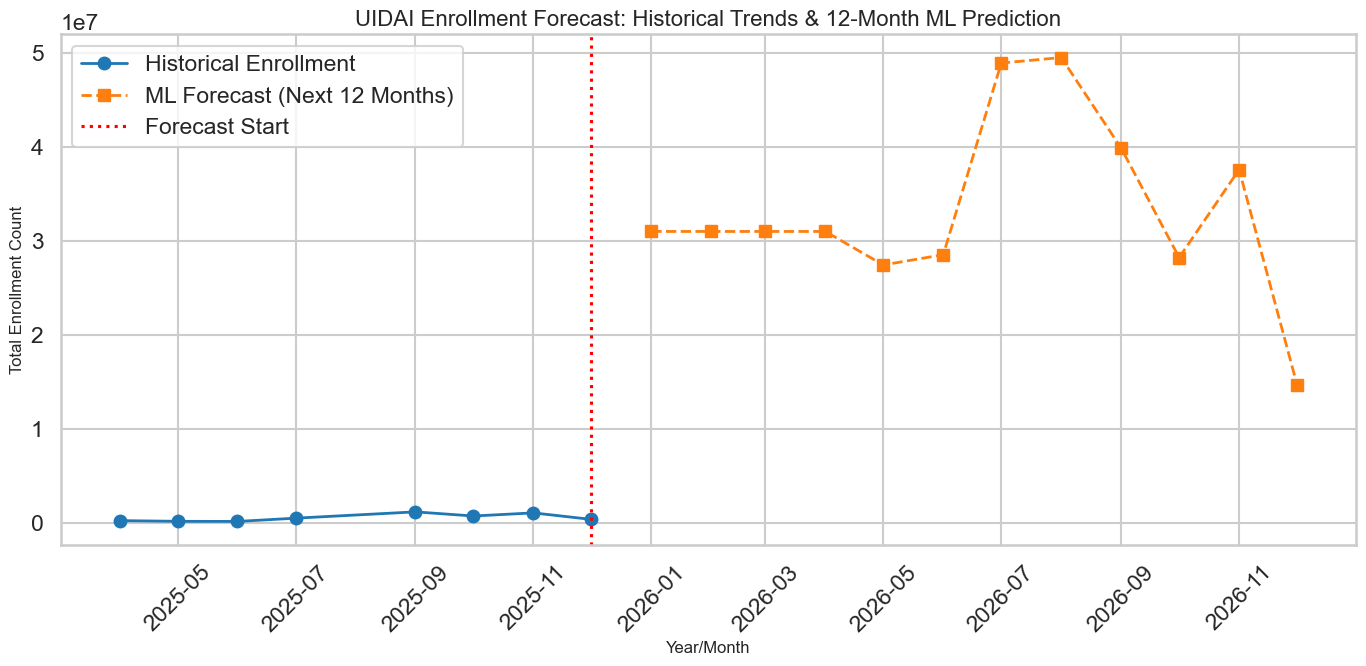

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Historical Data for Plotting
historical_plot = ml_data.groupby('date')['Total_Enrolment'].sum().reset_index()

# 2. Prepare Forecast Data for Plotting
# We group by forecast_date to get the national total forecast
forecast_plot = future_df.groupby('forecast_date')['Predicted_Enrolment'].sum().reset_index()

# 3. Plotting the Visualization
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot Historical Data
plt.plot(historical_plot['date'], historical_plot['Total_Enrolment'], 
         label='Historical Enrollment', color='#1f77b4', linewidth=2, marker='o')

# Plot Forecasted Data (Connecting from the last historical point)
plt.plot(forecast_plot['forecast_date'], forecast_plot['Predicted_Enrolment'], 
         label='ML Forecast (Next 12 Months)', color='#ff7f0e', linestyle='--', linewidth=2, marker='s')

# Adding a vertical line to show where the prediction starts
plt.axvline(x=historical_plot['date'].max(), color='red', linestyle=':', label='Forecast Start')

# Professional Formatting
plt.title('UIDAI Enrollment Forecast: Historical Trends & 12-Month ML Prediction', fontsize=16)
plt.xlabel('Year/Month', fontsize=12)
plt.ylabel('Total Enrollment Count', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure for your Seminar Presentation
plt.savefig('Enrollment_Prediction_Graph.png')
plt.show()

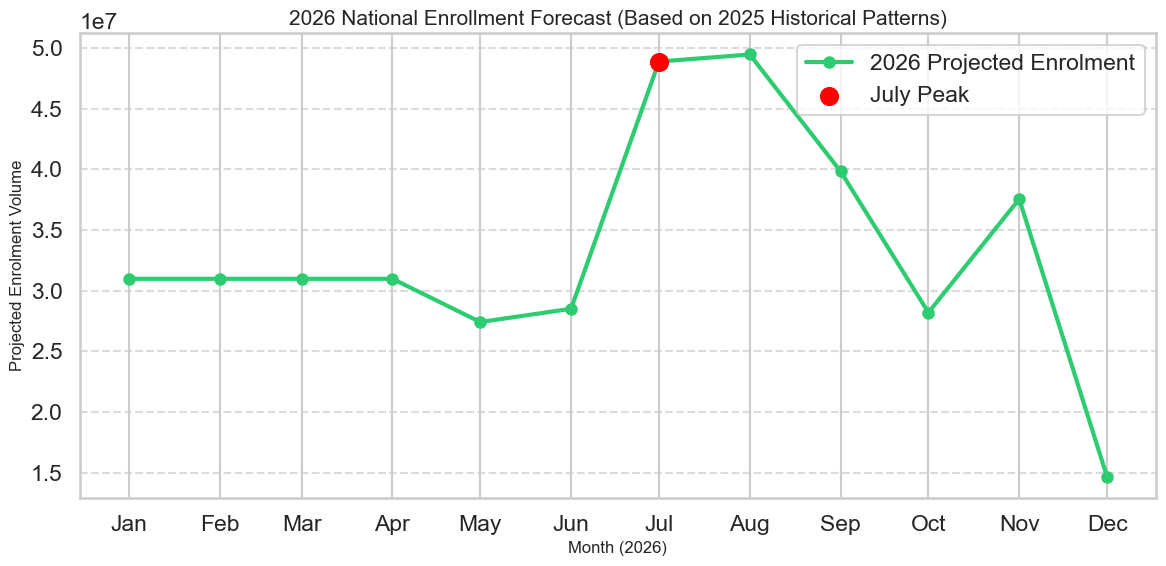

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure we are looking only at the 2026 forecast
# We filter the 'future_df' we created in the ML step
forecast_2026 = future_df[future_df['year'] == 2026].copy()

# 2. Group by month to get the National Total for each month of 2026
monthly_2026 = forecast_2026.groupby('forecast_date')['Predicted_Enrolment'].sum().reset_index()

# 3. Create the 2026 Prediction Graph
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plotting the forecast line
plt.plot(monthly_2026['forecast_date'], monthly_2026['Predicted_Enrolment'], 
         color='#2ecc71', marker='o', markersize=8, linewidth=3, label='2026 Projected Enrolment')

# Highlight the Peak (School Admission Season)
july_peak = monthly_2026[monthly_2026['forecast_date'].dt.month == 7]
if not july_peak.empty:
    plt.scatter(july_peak['forecast_date'], july_peak['Predicted_Enrolment'], color='red', s=150, zorder=5, label='July Peak')

# Formatting for the Seminar
plt.title('2026 National Enrollment Forecast (Based on 2025 Historical Patterns)', fontsize=15)
plt.xlabel('Month (2026)', fontsize=12)
plt.ylabel('Projected Enrolment Volume', fontsize=12)
plt.xticks(monthly_2026['forecast_date'], [d.strftime('%b') for d in monthly_2026['forecast_date']])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Save for your Power BI / Presentation
plt.savefig('UIDAI_2026_Forecast.png')
plt.show()

# Demographic & biometric Prediction 

In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 1. RE-SYNC ML DATA (Ensuring columns exist)
# We aggregate the totals from your master frames to match the ml_data structure
ml_bio = biometric_master.groupby(['date', 'state', 'district'])['Total_Biometric'].sum().reset_index()
ml_demo = demographic_master.groupby(['date', 'state', 'district'])['Total_Demographic'].sum().reset_index()

# Merge these back into your existing ml_data
ml_data = pd.merge(ml_data, ml_bio, on=['date', 'state', 'district'], how='left').fillna(0)
ml_data = pd.merge(ml_data, ml_demo, on=['date', 'state', 'district'], how='left').fillna(0)

# 2. TRAIN MODELS
X = ml_data[['state_cat', 'dist_cat', 'month_no', 'year']]

print("🧠 Training All Models...")
model_enrol = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, ml_data['Total_Enrolment'])
model_bio = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, ml_data['Total_Biometric'])
model_demo = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, ml_data['Total_Demographic'])

# 3. GENERATE PREDICTIONS
X_future = future_df[['state_cat', 'dist_cat', 'month_no', 'year']]

future_df['Predicted_Enrolment'] = model_enrol.predict(X_future)
future_df['Predicted_Biometric'] = model_bio.predict(X_future)
future_df['Predicted_Demographic'] = model_demo.predict(X_future)

# 4. EXPORT FOR POWER BI
# We use standard column names for easy mapping in Power BI
export_df = future_df[['forecast_date', 'state', 'district', 
                       'Predicted_Enrolment', 'Predicted_Biometric', 'Predicted_Demographic']].copy()

export_df['forecast_date'] = export_df['forecast_date'].dt.strftime('%Y-%m-%d')
export_df.to_csv("UIDAI_Final_Forecast_2026.csv", index=False)

print("✅ File Created: UIDAI_Final_Forecast_2026.csv")
print("🚀 Ready for Power BI Import!")



🧠 Training All Models...
✅ File Created: UIDAI_Final_Forecast_2026.csv
🚀 Ready for Power BI Import!


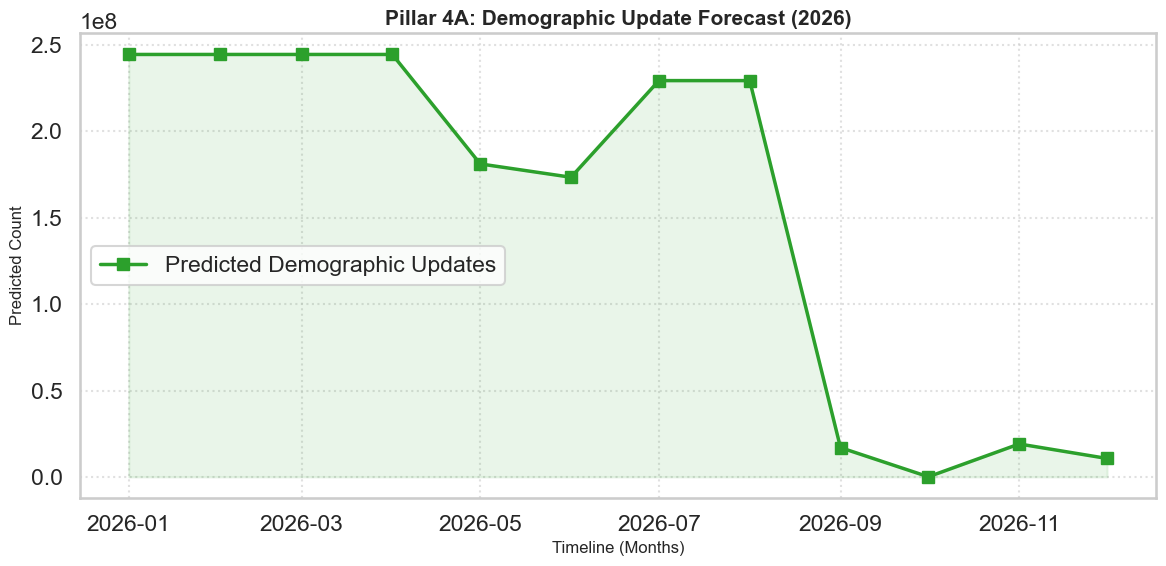

In [46]:
# demographic future analysis visualization
import matplotlib.pyplot as plt

demo_forecast = future_df.groupby('forecast_date')['Predicted_Demographic'].sum().reset_index()

# २. ग्राफ प्लॉट करणे
plt.figure(figsize=(12, 6))
plt.plot(demo_forecast['forecast_date'], demo_forecast['Predicted_Demographic'], 
         marker='s', color='#2ca02c', label='Predicted Demographic Updates', linewidth=2.5)

plt.fill_between(demo_forecast['forecast_date'], demo_forecast['Predicted_Demographic'], color='#2ca02c', alpha=0.1)
plt.title('Pillar 4A: Demographic Update Forecast (2026)', fontsize=15, fontweight='bold')
plt.xlabel('Timeline (Months)', fontsize=12)
plt.ylabel('Predicted Count', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.savefig('demographic_prediction_2026.png')
plt.show()

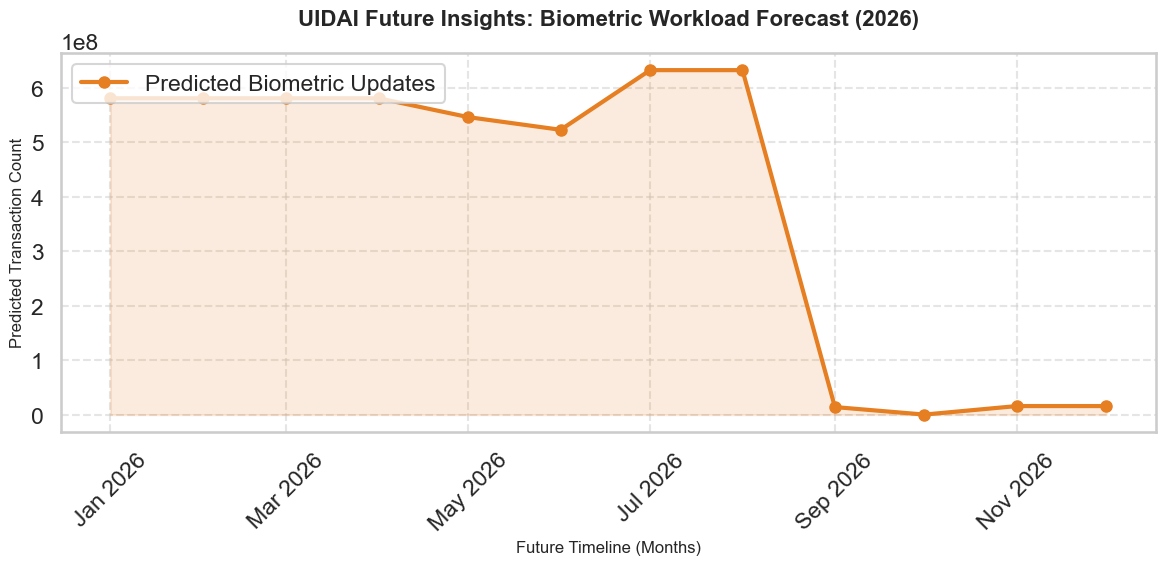

📊 2026 Total Biometric: 4,703,408,382


In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

bio_forecast = future_df.groupby('forecast_date')['Predicted_Biometric'].sum().reset_index()


plt.figure(figsize=(12, 6))

plt.plot(bio_forecast['forecast_date'], bio_forecast['Predicted_Biometric'], 
         marker='o', markersize=8, color='#e67e22', linewidth=3, label='Predicted Biometric Updates')

plt.fill_between(bio_forecast['forecast_date'], bio_forecast['Predicted_Biometric'], color='#e67e22', alpha=0.15)


plt.title('UIDAI Future Insights: Biometric Workload Forecast (2026)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Future Timeline (Months)', fontsize=12)
plt.ylabel('Predicted Transaction Count', fontsize=12)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout()
plt.savefig('biometric_forecast_2026.png', dpi=300)
plt.show()

print(f"📊 2026 Total Biometric: {int(bio_forecast['Predicted_Biometric'].sum()):,}")